Analyze state of the union addresses. 
Data source: https://en.wikisource.org/wiki/Portal:State_of_the_Union_Speeches_by_United_States_Presidents
scrape the text of all speeches and then maybe try to find patterns of speech of each president?

https://nlp.stanford.edu/IR-book/html/htmledition/sublinear-tf-scaling-1.html 
https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html 

## Setup

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import urllib.request
import re
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt


# Data source we are going to scrape for results
data_url = 'https://en.wikisource.org/wiki/Portal:State_of_the_Union_Speeches_by_United_States_Presidents'

link_list = []

resp = urllib.request.urlopen(data_url)
soup = BeautifulSoup(resp, from_encoding=resp.info().get_param('charset'))

# Get all links to state of the union addresses from 
for link in soup.find_all('a', href=True):
    if "union_address" in link['href'].lower() or "union_speech" in link['href'].lower() \
        and "portal" not in link['href'].lower() and "#" not in link['href'].lower():
        link_list.append(link['href'])

# extract the text of a speech from a URL
# text is extracted in a list of paragraphs (strings) for each speech
def get_speech(url):
    return([ p.text.strip() for p in BeautifulSoup(urllib.request.urlopen(url)).find_all("p") if \
             'This work is in the public domain in the United States because it is a work of the United States federal government' \
             not in p.text.strip()])


## Web Scraping

In [2]:
speeches = [get_speech('https://en.wikisource.org' + link) for link in link_list]
# Extract presidents names from link text
presidents = [ link.replace('%','/').split('/')[2].replace('_',' ') for link in link_list ]

# Extract state of the union text entries so we can extract the date
sou_entries = []
for item in soup.find_all('li'):
    if 'union' in item.text.strip().lower() and '(' in  item.text.strip().lower():
        sou_entries.append(item.text.strip())

speeches_pd = pd.DataFrame({
                'president' : presidents,
                'speech' : speeches,
                'year' : [int(re.findall('\d+',item)[1]) for item in sou_entries ]} )
        

In [3]:
speeches_pd.sample(n=10)

,president,speech,year
150,Franklin Delano Roosevelt,"[Mr. Vice President, Mr. Speaker, Members of t...",1940
28,James Monroe,[Fellow-Citizens of the Senate and House of Re...,1817
36,John Quincy Adams,[Fellow Citizens of the Senate and of the Hous...,1825
67,Franklin Pierce,[Fellow-Citizens of the Senate and of the Hous...,1856
87,Ulysses S. Grant,"[To the Senate and House of Representatives:, ...",1876
222,Barack Obama,"[Madam Speaker, Vice President Biden, members ...",2010
46,Andrew Jackson,[Fellow Citizens of the Senate and of the Hous...,1835
125,Woodrow Wilson,"[GENTLEMEN OF THE CONGRESS:, The session upon ...",1914
34,James Monroe,[Fellow-Citizens of the Senate and House of Re...,1823
122,William Howard Taft,"[To the Senate and House of Representatives:, ...",1911


## Pre-process and TfIdf Vectorize Speeches

In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

lmtzr = WordNetLemmatizer()

## NOTE - these two functions for POS tagging and lemmatization
## are much slower than the spacy alternative
# Convert nltk POS to POS that can be used by lemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

# Lemmatize a word with its appropriate POS tag
def lemmatize_with_pos(word,testing=False):
    pos = get_wordnet_pos(nltk.pos_tag([word])[0][1])
    if testing==True:
        print('POS: ' + pos)
    if pos != '':
        return(lmtzr.lemmatize(word,pos))
    else:
        return(lmtzr.lemmatize(word))
    
MyStopWords = get_stop_words('en')
MyStopWords.extend(['make','will','can','applause'])

In [5]:
lemmatize_with_pos('treaties',testing=True)

POS: n


'treaty'

Clean, Tokenize, Lemmatize, and Vectorize all speeches 

In [10]:
# Each speech is stored as a list of paragraph strings. 
# Here we join the paragraphs into a single speech string
speech_list = [" ".join(speech) for speech in speeches_pd['speech'].tolist() ]

# Only use the last X years to make the topic modeling a bit easier
selected_speeches = speech_list[len(speech_list)-31:(len(speech_list)-1)]

In [7]:
# WARNING - this step may take a few minutes
tokens = [[lemmatize_with_pos(word.lower()) for word in word_tokenize(speech) if \
          word.isalpha() and word.lower() not in MyStopWords ] for \
          speech in selected_speeches ]

In [8]:
# Tfidf Vectorize
tvec = TfidfVectorizer(ngram_range=(1,1))
texts = [" ".join(tok) for tok in tokens ]
tfidf = pd.DataFrame(tvec.fit_transform(texts).toarray(),
                    columns  = tvec.get_feature_names())
#corpus = Sparse2Corpus(tvec.fit_transform(texts), documents_columns=False)

In [9]:
from gensim.corpora.dictionary import Dictionary
# Create a corpus from a list of texts
common_dictionary = Dictionary(tokens)
corpus = [common_dictionary.doc2bow(text) for text in tokens]

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [10]:
print(tfidf.shape)

(30, 6524)


## Gensim Topic Modeling

https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb

In [200]:
import gensim
from gensim import corpora, models

gensimLDA = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = common_dictionary, passes=20)

In [292]:
gensimLDA.show_topics(formatted=True,num_words=15)

[(0,
  '0.012*"america" + 0.010*"world" + 0.009*"american" + 0.008*"nation" + 0.007*"new" + 0.007*"year" + 0.007*"u" + 0.006*"know" + 0.006*"child" + 0.006*"must" + 0.005*"now" + 0.005*"every" + 0.005*"people" + 0.005*"freedom" + 0.005*"one"'),
 (1,
  '0.000*"american" + 0.000*"year" + 0.000*"work" + 0.000*"america" + 0.000*"u" + 0.000*"now" + 0.000*"people" + 0.000*"s" + 0.000*"job" + 0.000*"every" + 0.000*"world" + 0.000*"one" + 0.000*"let" + 0.000*"must" + 0.000*"congress"'),
 (2,
  '0.009*"america" + 0.009*"must" + 0.009*"people" + 0.008*"american" + 0.008*"nation" + 0.008*"iraq" + 0.007*"year" + 0.007*"country" + 0.007*"world" + 0.007*"terrorist" + 0.006*"security" + 0.006*"iraqi" + 0.005*"freedom" + 0.005*"government" + 0.005*"great"'),
 (3,
  '0.014*"s" + 0.011*"american" + 0.010*"year" + 0.009*"america" + 0.008*"job" + 0.008*"work" + 0.008*"new" + 0.007*"u" + 0.007*"people" + 0.006*"t" + 0.005*"help" + 0.005*"need" + 0.005*"country" + 0.005*"get" + 0.005*"one"'),
 (4,
  '0.015*

In [270]:
doc_top_proportions = [ gensimLDA.get_document_topics(doc,minimum_probability=0) for doc in corpus ]

In [284]:
doc_top_probs = pd.DataFrame([[prob for (topic, prob) in prob_tuple] for prob_tuple in doc_top_proportions])
doc_top_probs['MostCommonTopic'] = doc_top_probs.idxmax(axis=1)

In [289]:
doc_top_probs.head(20)

,0,1,2,3,4,5,6,7,8,9,MostCommonTopic
0,0.000040,0.000040,0.000251,0.000040,0.000040,0.000040,0.999431,0.000040,0.000040,0.000040,6
1,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.999628,0.000041,0.000041,0.000041,6
2,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.999522,0.000053,0.000053,0.000053,6
3,0.999530,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0
4,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.999634,0.000041,0.000041,0.000041,6
5,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.999727,0.000030,0.000030,0.000030,6
6,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,0.999756,0.000027,0.000027,0.000027,6
7,0.000023,0.000023,0.000023,0.000023,0.976299,0.000023,0.023515,0.000023,0.000023,0.000023,4
8,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.999714,0.000032,0.000032,0.000032,6
9,0.000029,0.000029,0.000029,0.000029,0.000029,0.000029,0.999741,0.000029,0.000029,0.000029,6


In [286]:
doc_top_probs.drop('MostCommonTopic',axis=1).idxmax(axis=0)

0     3
1     2
2    15
3    24
4     7
5    11
6    12
7    14
8     2
9     2
dtype: int64

In [254]:
test = pd.DataFrame(doc_top_proportions)

In [281]:
selected_speeches[14][:500]

'Thank you very much. Mr. Speaker, Vice President Cheney, members of Congress, distinguished guests, fellow citizens: As we gather tonight, our nation is at war, our economy is in recession, and the civilized world faces unprecedented dangers. Yet the state of our Union has never been stronger. We last met in an hour of shock and suffering. In four short months, our nation has comforted the victims, begun to rebuild New York and the Pentagon, rallied a great coalition, captured, arrested, and rid'

## SkLearn Topic Modeling

In [135]:
## LDA Topic Modeling
speech_lda = LatentDirichletAllocation(n_components=8,
                                       random_state=1,
                                    #   evaluate_every=0.5, # eval perplexity
                                    #   perp_tol=0.05,
                                       max_iter=50,
                                learning_method='online'
                                      )

speech_lda.fit(tfidf) # fit model

# % makeup of each document by topic
doc_topic = pd.DataFrame(speech_lda.transform(tfidf),
                        columns=list(range(0,(speech_lda.n_components))))

# What was the most common topic in each document?
doc_topic['MostCommonTopic'] = doc_topic.idxmax(axis=1)


In [136]:
# In which document did each topic most commonly occur?
doc_topic.idxmax(axis=0)

0                  15
1                  23
2                  15
3                  15
4                  15
5                  15
6                  15
7                  15
MostCommonTopic     0
dtype: int64

In [137]:
doc_topic.head(5)

,0,1,2,3,4,5,6,7,MostCommonTopic
0,0.004376,0.969368,0.004376,0.004376,0.004376,0.004376,0.004376,0.004376,1
1,0.004121,0.971152,0.004121,0.004121,0.004121,0.004121,0.004121,0.004121,1
2,0.004231,0.970384,0.004231,0.004231,0.004231,0.004231,0.004231,0.004231,1
3,0.004177,0.970764,0.004177,0.004177,0.004177,0.004177,0.004177,0.004177,1
4,0.003938,0.972431,0.003938,0.003938,0.003938,0.003938,0.003938,0.003938,1


In [138]:
# Print the top words for topics in the topic model
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()    

print_top_words(speech_lda, tfidf.columns.values, 12)

Topic #0: america year ancestry country state positive maternity thank incentive tonight millionaire congressional
Topic #1: year american america people must new nation world work congress now government
Topic #2: woman bring come task arsenal people must day competency viable family give
Topic #3: coma trust readjustment hanoi khalid michel sent caregiver criticize workable dan grassroots
Topic #4: another berthing anywhere redevelopment astern need ambitiously fiction protectionism complicate scientist rebate
Topic #5: year must american nation people world state america government now service job
Topic #6: ambition impetus despair cruel resourceful dramatic hard theodore immunize integral fundamental eventful
Topic #7: american america new enacts state soviet world lebanon register repression disruption aspect



In [139]:
doc_topic.shape

(60, 9)

## Sentiment Analysis

In [108]:
sentiments = [TextBlob(text).sentiment for text in speech_list ] 

speeches_pd['polarity'] = [ i[0] for i in sentiments]
speeches_pd['subjectivity'] = [ i[1] for i in sentiments]

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


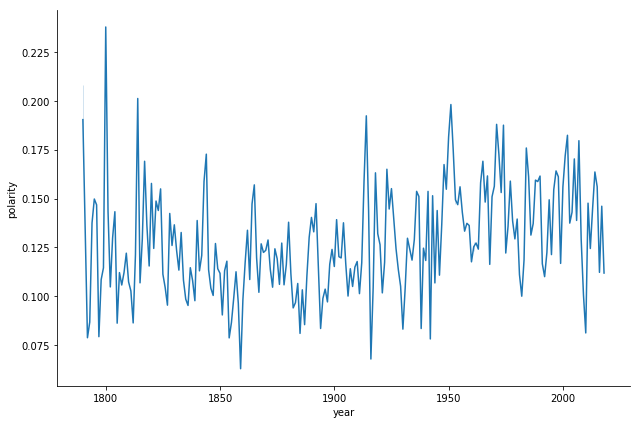

In [110]:
sns.relplot(x="year", y="polarity", data=speeches_pd,kind="line",height=6,aspect=1.5)

## Spacy

Test out spacy as a (hopefully faster) alternative to NLTK lemmatization

In [81]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner']) # disabling the parser makes it run faster
doc = nlp('This is a sentence.')

In [75]:
doc[2].lemma_

'a'

In [72]:
doc[0].text.lower()

'this'

In [76]:
# Preprocess pipeline with spacy. 
def spacy_preprocess(text):  # clean up your text and generate list of words for each document. 
    text_out = []
    doc= nlp(text)
    for token in doc:
        # Get rid of stop words and non-alphanumeric
        if token.is_stop == False and token.is_alpha and len(token)>2:
            lemma = token.lemma_
            if lemma != '-PRON-':
                text_out.append(lemma)
            else:
                text_out.append(token.text.lower())            
    return(text_out)

In [78]:
spacy_preprocess('This Osama Bin Laden UPPER BOB TOM ALLEN AFGHANISTAN dsfdsf sd 343 2 4wr234 data science running run run')

['this',
 'osama',
 'bin',
 'laden',
 'upper',
 'bob',
 'tom',
 'allen',
 'afghanistan',
 'dsfdsf',
 'datum',
 'science',
 'run',
 'run',
 'run']

In [5]:
test_doc = 'I am running jumping presidents applause now beaches'

In [6]:
test_nlp = nlp(test_doc)

## Preprocessing Speed Test

In [80]:
import time
# Test NLTK method
start = time.time()
# WARNING - this step may take a few minutes
nltk_tokens = [[lemmatize_with_pos(word.lower()) for word in word_tokenize(speech) if \
          word.isalpha() and word.lower() not in MyStopWords ] for \
          speech in selected_speeches ]
print('NLTK method time elapsed: ' + str(time.time()-start))

# Test Spacy
start = time.time()
# WARNING - this step may take a few minutes
spacy_tokens = [spacy_preprocess(speech) for \
          speech in selected_speeches ]
print('Spacy method time elapsed: ' + str(time.time()-start))

NLTK method time elapsed: 97.75806975364685
Spacy method time elapsed: 16.999743938446045


In [83]:
i=15
print(len(nltk_tokens[i]))
print(len(spacy_tokens[i]))
print(nltk_tokens[i][10:40])
print(spacy_tokens[i][10:40])

2823
2709
['every', 'year', 'law', 'custom', 'meet', 'consider', 'state', 'union', 'year', 'gather', 'chamber', 'deeply', 'aware', 'decisive', 'day', 'lie', 'ahead', 'serve', 'country', 'time', 'great', 'consequence', 'session', 'congress', 'duty', 'reform', 'domestic', 'program', 'vital', 'country']
['every', 'year', 'law', 'custom', 'meet', 'consider', 'state', 'union', 'this', 'year', 'gather', 'chamber', 'deeply', 'aware', 'decisive', 'day', 'lie', 'ahead', 'you', 'serve', 'country', 'time', 'great', 'consequence', 'during', 'session', 'congress', 'duty', 'reform', 'domestic']
